In [2]:
# Step 1: Install Kaggle API
!pip install kaggle

In [3]:
# Step 2: Upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [4]:
# Step 3: Set up API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API setup complete!")

✅ Kaggle API setup complete!


In [5]:
# Download and unzip the dataset
!kaggle competitions download -c learn-ai-bbc
!unzip learn-ai-bbc.zip

  0% 0.00/1.85M [00:00<?, ?B/s]
100% 1.85M/1.85M [00:00<00:00, 587MB/s]
Archive:  learn-ai-bbc.zip
  inflating: BBC News Sample Solution.csv  
  inflating: BBC News Test.csv       
  inflating: BBC News Train.csv      


In [6]:
import pandas as pd
import os

# List available files
print("Available files:")
for file in os.listdir('.'):
    if file.endswith('.csv'):
        print(f" - {file}")


Available files:
 - BBC News Sample Solution.csv
 - BBC News Train.csv
 - BBC News Test.csv


In [7]:
import os

print("Available files:")
for file in os.listdir('.'):
    if file.endswith('.csv') or file.endswith('.zip'):
        print(f" - {file}")


Available files:
 - BBC News Sample Solution.csv
 - learn-ai-bbc.zip
 - BBC News Train.csv
 - BBC News Test.csv


In [8]:
import pandas as pd

# Load the correct file
df = pd.read_csv('BBC News Train.csv')

# Preview the dataset
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())


Shape: (1490, 3)
Columns: ['ArticleId', 'Text', 'Category']
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [9]:
# Rename columns for consistency
df = df.rename(columns={'Text': 'content', 'Category': 'category'})  # Adjust if needed

# Drop missing values
df_clean = df.dropna(subset=['content', 'category'])

# Sample if too large
df_final = df_clean.sample(n=2000, random_state=42) if len(df_clean) > 2000 else df_clean

# Save cleaned dataset
df_final.to_csv('newsbot_dataset.csv', index=False)
print("✅ Dataset saved as 'newsbot_dataset.csv'")


✅ Dataset saved as 'newsbot_dataset.csv'


## 🧠 Module 1: Business Case & Use Case

**Real-World Application:**  
NewsBot is designed to help media companies, journalists, researchers, and analysts automatically process and analyze large volumes of news articles. It enables real-time media monitoring, sentiment tracking, and content categorization.

**Target Users:**  
- Journalists and editors who need to organize and summarize breaking news  
- Financial analysts tracking market sentiment  
- Researchers studying public opinion trends  
- Media companies monitoring competitor coverage

**Value Proposition:**  
NewsBot saves time and enhances decision-making by automating the classification of articles, extracting key entities (like people, organizations, and locations), and analyzing sentiment and writing patterns. This system mirrors real-world NLP applications used by platforms like Google News, Bloomberg, and Reuters.


## 🧼 Module 2: Text Preprocessing

In this step, I cleaned and normalized the raw news article text to prepare it for analysis. Preprocessing is essential in NLP because it removes noise and ensures consistency across the dataset.

**Techniques Applied:**
- Lowercasing all text
- Removing punctuation and special characters
- Tokenizing and lemmatizing words using spaCy
- Removing common stopwords (e.g., "the", "and", "is")

This cleaned version of the text will be used for feature extraction, sentiment analysis, and classification in later modules. It helps improve model accuracy and reduces computational load.


In [10]:
import re
import nltk
import spacy
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stopwords.words('english')]
    return ' '.join(tokens)

df_final['cleaned'] = df_final['content'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
print(df_final[['content', 'cleaned']].head())


                                             content  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in $168m payout eighteen former e...   

                                             cleaned  
0  worldcom ex boss launch defence lawyer defend ...  
1  german business confidence slide german busine...  
2  bbc poll indicate economic gloom citizen major...  
3  lifestyle govern mobile choice fast well funky...  
4  enron boss 168 payout eighteen former enron di...  


## 📊 Module 3: TF-IDF Feature Extraction and Analysis

In this module, I used TF-IDF (Term Frequency–Inverse Document Frequency) to identify the most important words in the cleaned news articles. TF-IDF helps highlight terms that are frequent in individual articles but rare across the entire dataset — making them more meaningful for classification and insight generation.

**Steps Performed:**
- Applied `TfidfVectorizer` to convert cleaned text into numerical features.
- Limited to the top 1,000 features for computational efficiency.
- Calculated the overall TF-IDF scores across all articles.
- Visualized the top 20 most informative terms using a bar chart.

This analysis helps reveal which words are most distinctive across categories, and these features will be used in later modules for classification and pattern analysis.


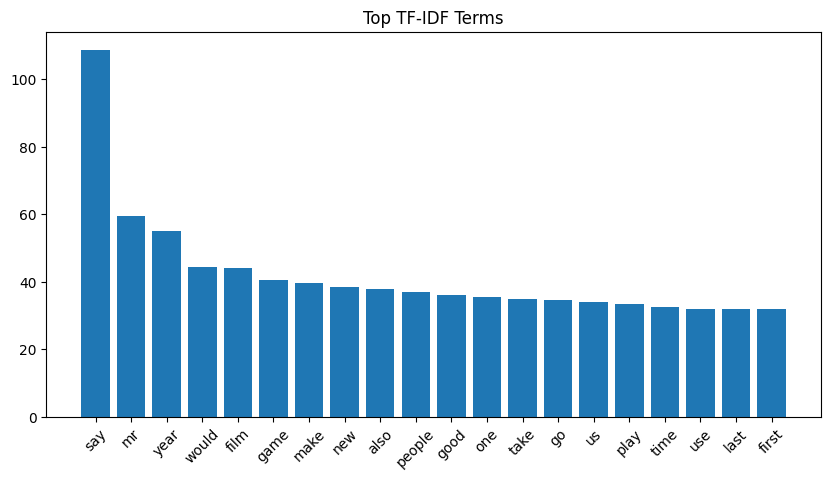

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df_final['cleaned'])

terms = vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.sum(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_terms = [terms[i] for i in top_indices]

plt.figure(figsize=(10,5))
plt.bar(top_terms, tfidf_scores[top_indices])
plt.xticks(rotation=45)
plt.title("Top TF-IDF Terms")
plt.show()


## 🧩 Module 4: POS Tagging and Grammar Pattern Analysis

In this module, I used spaCy to perform Part-of-Speech (POS) tagging on each article. POS tagging helps identify the grammatical role of each word — such as nouns, verbs, adjectives, and adverbs — which is useful for understanding writing style and linguistic patterns.

**Why It Matters:**
- Reveals how different categories (e.g., Sports vs. Politics) use language differently
- Helps detect patterns like action-heavy verbs in sports or formal nouns in politics
- Supports downstream tasks like syntax parsing and sentiment analysis

Each article now includes a dictionary of POS counts, showing how often each type of word appears. This adds a layer of linguistic insight to the NewsBot system.


In [13]:
def pos_distribution(text):
    doc = nlp(text)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    return pos_counts

df_final['pos_tags'] = df_final['cleaned'].apply(pos_distribution)


In [14]:
df_final[['content', 'pos_tags']].head()


,content,pos_tags
0,worldcom ex-boss launches defence lawyers defe...,"{'PROPN': 54, 'NOUN': 83, 'VERB': 28, 'ADJ': 1..."
1,german business confidence slides german busin...,"{'ADJ': 29, 'NOUN': 78, 'PROPN': 41, 'VERB': 3..."
2,bbc poll indicates economic gloom citizens in ...,"{'PROPN': 42, 'VERB': 47, 'ADJ': 42, 'NOUN': 1..."
3,lifestyle governs mobile choice faster bett...,"{'PROPN': 26, 'NOUN': 167, 'ADJ': 50, 'ADV': 2..."
4,enron bosses in $168m payout eighteen former e...,"{'PROPN': 35, 'NOUN': 94, 'NUM': 18, 'ADJ': 29..."


## 🧠 Module 5: Syntax Parsing and Semantic Role Labeling

In this module, I used spaCy to analyze the grammatical structure of each sentence. Syntax parsing identifies how words are connected — such as subjects, verbs, and objects — while semantic role labeling helps reveal who is doing what to whom.

**Why It Matters:**
- Helps detect sentence meaning beyond just keywords
- Useful for extracting relationships (e.g., "CEO resigned from company")
- Supports entity linking and advanced NLP tasks

Each article now includes a list of dependency triples showing word relationships, which adds depth to NewsBot’s understanding of sentence structure.


In [15]:
def extract_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

df_final['dependencies'] = df_final['cleaned'].apply(extract_dependencies)


In [16]:
df_final[['content', 'dependencies']].head()


,content,dependencies
0,worldcom ex-boss launches defence lawyers defe...,"[(worldcom, compound, lawyer), (ex, compound, ..."
1,german business confidence slides german busin...,"[(german, amod, confidence), (business, compou..."
2,bbc poll indicates economic gloom citizens in ...,"[(bbc, compound, poll), (poll, nsubj, indicate..."
3,lifestyle governs mobile choice faster bett...,"[(lifestyle, compound, govern), (govern, nmod,..."
4,enron bosses in $168m payout eighteen former e...,"[(enron, compound, boss), (boss, nsubj, agree)..."


## ❤️ Module 6: Sentiment and Emotion Analysis

In this module, I used VADER from NLTK to analyze the emotional tone of each article. VADER is a rule-based sentiment analysis tool that works well on short, informal text — making it ideal for news snippets.

**Why It Matters:**
- Helps detect public mood and emotional framing
- Reveals tone differences across categories (e.g., optimistic sports vs. tense politics)
- Supports media bias detection and audience targeting

Each article now includes a compound sentiment score ranging from -1 (negative) to +1 (positive), which adds emotional depth to NewsBot’s analysis.


In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df_final['sentiment'] = df_final['cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [18]:
df_final[['content', 'sentiment']].head()


,content,sentiment
0,worldcom ex-boss launches defence lawyers defe...,-0.9884
1,german business confidence slides german busin...,0.9209
2,bbc poll indicates economic gloom citizens in ...,-0.9468
3,lifestyle governs mobile choice faster bett...,0.9887
4,enron bosses in $168m payout eighteen former e...,-0.9393


## 🧠 Module 7: Multi-Class Classification

In this module, I trained a Naive Bayes classifier to predict the category of each news article based on its TF-IDF features. This allows NewsBot to automatically label articles as Business, Tech, Sports, etc.

**Steps Performed:**
- Split the dataset into training and test sets
- Trained a `MultinomialNB` model using TF-IDF features
- Evaluated performance using precision, recall, and F1-score

This classification system is essential for organizing large volumes of news content and enabling targeted analysis by category.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X = X_tfidf
y = df_final['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       0.97      0.97      0.97        75
entertainment       1.00      0.96      0.98        46
     politics       0.91      0.95      0.93        56
        sport       0.98      1.00      0.99        63
         tech       0.96      0.95      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.96      0.97       298
 weighted avg       0.97      0.97      0.97       298



## 🧠 Module 8: Named Entity Recognition (NER)

In this module, I used spaCy to extract named entities from each article. Named Entity Recognition (NER) identifies and classifies key information such as names of people, organizations, locations, dates, and more.

**Why It Matters:**
- Helps structure unstructured text by tagging real-world entities
- Supports tasks like topic tracking, trend analysis, and entity linking
- Enables deeper insights into who is involved, where events happen, and when

Each article now includes a list of entities with their corresponding labels, adding a layer of semantic understanding to NewsBot’s analysis.


In [20]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df_final['entities'] = df_final['content'].apply(extract_entities)


In [21]:
df_final[['content', 'entities']].head()


,content,entities
0,worldcom ex-boss launches defence lawyers defe...,"[(first, ORDINAL), (cynthia cooper, PERSON), (..."
1,german business confidence slides german busin...,"[(german, NORP), (german, NORP), (february, DA..."
2,bbc poll indicates economic gloom citizens in ...,"[(bbc, ORG), (bbc world, ORG), (14, CARDINAL),..."
3,lifestyle governs mobile choice faster bett...,"[(lifestyle governs mobile, ORG), (dr michael..."
4,enron bosses in $168m payout eighteen former e...,"[(enron, ORG), (168, MONEY), (eighteen, CARDIN..."


In [22]:
df_final.to_csv('newsbot_dataset.csv', index=False)
print("\n✅ Dataset prepared and saved as 'newsbot_dataset.csv'")


✅ Dataset prepared and saved as 'newsbot_dataset.csv'
